In [1]:
## Below code required to access Google drive resources
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# Keras and TF imports
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import SGD, RMSprop, Adagrad

Using TensorFlow backend.


In [2]:
# Scikit-learn and Numpy imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [3]:
# set the location of the training and test images (change as required)
location_of_train_data = "../../Chess ID Public Data/output_train"
location_of_test_data = "../../Chess ID Public Data/output_test"
model_folder_name = "../models/15_12"

In [4]:
class_names = ["bishop", "king", "knight", "pawn", "queen", "rook", "empty"]
class_names_reverse_mappings = {"bishop": 0, "king": 1, "knight":2, "pawn":3, "queen":4, "rook":5, "empty":6}
class_names_folder_mappings = {"bishop": ["bb", "wb"], "king": ["bk", "wk"], "knight":["bn", "wn"], "pawn":["bp", "wp"], "queen":["bq", "wq"], "rook":["br", "wr"], "empty":["empty"]}

In [5]:
from keras.applications.inception_v3 import preprocess_input

def get_required_data_with_labels_for_model(base_location, num_samples = None, dimensions=(299, 299)):
  X, y = [], []
  for class_name in class_names_folder_mappings:
    for folder_name in class_names_folder_mappings[class_name]:
      complete_path = os.path.join(base_location, folder_name)
      print("Reading the files from the location {0}".format(complete_path))
      current_samples = 0
      for image_file_name in os.listdir(complete_path):
        
        # check if the current file is an image file with jpg extension
        if image_file_name.endswith(".jpg"):
          current_samples += 1
          img_path = os.path.join(complete_path, image_file_name)
          
          # basic pre-processing of the images
          img = image.load_img(img_path, target_size=dimensions)
          x = image.img_to_array(img)
          x = preprocess_input(x)
          
          X.append(x)
          class_name_id = class_names_reverse_mappings[class_name]
          y.append(class_name_id)
        
          if ((num_samples is not None) and (current_samples == num_samples)):
            break
  
  return X, y    
  

In [6]:
X, y = get_required_data_with_labels_for_model(location_of_train_data)
print(len(X))
print(len(y))
print(X[0].shape)
print(y[0])

Reading the files from the location ../../Chess ID Public Data/output_train\bb
Reading the files from the location ../../Chess ID Public Data/output_train\wb
Reading the files from the location ../../Chess ID Public Data/output_train\bk
Reading the files from the location ../../Chess ID Public Data/output_train\wk
Reading the files from the location ../../Chess ID Public Data/output_train\bn
Reading the files from the location ../../Chess ID Public Data/output_train\wn
Reading the files from the location ../../Chess ID Public Data/output_train\bp
Reading the files from the location ../../Chess ID Public Data/output_train\wp
Reading the files from the location ../../Chess ID Public Data/output_train\bq
Reading the files from the location ../../Chess ID Public Data/output_train\wq
Reading the files from the location ../../Chess ID Public Data/output_train\br
Reading the files from the location ../../Chess ID Public Data/output_train\wr
Reading the files from the location ../../Chess ID P

In [7]:
# X_test, y_test = get_required_data_with_labels_for_model(location_of_test_data)
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(9324, 299, 299, 3)
(1036, 299, 299, 3)
9324
1036


In [8]:
## update the base inception v3 model

num_output_classes = len(class_names)

# create the base pre-trained model
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = inception_v3_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_output_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inception_v3_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in inception_v3_model.layers:
    layer.trainable = False

opt = RMSprop(lr=0.00001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
if not os.path.exists(model_folder_name):
    os.makedirs(model_folder_name)

In [10]:
# checkpoint
filepath=os.path.join(model_folder_name, "chess_pieces_inceptionv3_p1.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=100, min_delta= 0.0001)
callbacks_list = [checkpoint, early_stopping]

In [11]:
epochs = 500
batch_size = 200

In [ ]:
#X_train = np.array(X_train)
#X_test = np.array(X_test)
history = model.fit(X_train,
          y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=callbacks_list,
          batch_size=batch_size)

Train on 9324 samples, validate on 1036 samples
Epoch 1/500
9324/9324 [==============================] - 41s 4ms/step - loss: 1.5518 - acc: 0.5446 - val_loss: 1.5538 - val_acc: 0.5975

Epoch 00001: val_acc improved from -inf to 0.59749, saving model to ../models/15_12\chess_pieces_inceptionv3_p1.hdf5
Epoch 2/500
9324/9324 [==============================] - 30s 3ms/step - loss: 1.2065 - acc: 0.6229 - val_loss: 1.4070 - val_acc: 0.6062

Epoch 00002: val_acc improved from 0.59749 to 0.60618, saving model to ../models/15_12\chess_pieces_inceptionv3_p1.hdf5
Epoch 3/500
9324/9324 [==============================] - 30s 3ms/step - loss: 1.0056 - acc: 0.6608 - val_loss: 1.3422 - val_acc: 0.6062

Epoch 00003: val_acc did not improve from 0.60618
Epoch 4/500
9324/9324 [==============================] - 30s 3ms/step - loss: 0.8641 - acc: 0.7177 - val_loss: 1.2834 - val_acc: 0.6062

Epoch 00004: val_acc did not improve from 0.60618
Epoch 5/500
9324/9324 [==============================] - 30s 3ms/st

9324/9324 [==============================] - 30s 3ms/step - loss: 0.1622 - acc: 0.9626 - val_loss: 2.0208 - val_acc: 0.6438

Epoch 00039: val_acc did not improve from 0.64961
Epoch 40/500
9324/9324 [==============================] - 31s 3ms/step - loss: 0.1618 - acc: 0.9635 - val_loss: 1.9109 - val_acc: 0.6486

Epoch 00040: val_acc did not improve from 0.64961
Epoch 41/500
9324/9324 [==============================] - 31s 3ms/step - loss: 0.1589 - acc: 0.9626 - val_loss: 1.9489 - val_acc: 0.6477

Epoch 00041: val_acc did not improve from 0.64961
Epoch 42/500
9324/9324 [==============================] - 30s 3ms/step - loss: 0.1533 - acc: 0.9651 - val_loss: 1.8802 - val_acc: 0.6506

Epoch 00042: val_acc improved from 0.64961 to 0.65058, saving model to ../models/15_12\chess_pieces_inceptionv3_p1.hdf5
Epoch 43/500
9324/9324 [==============================] - 30s 3ms/step - loss: 0.1522 - acc: 0.9648 - val_loss: 1.9260 - val_acc: 0.6477

Epoch 00043: val_acc did not improve from 0.65058
Epo

9324/9324 [==============================] - 30s 3ms/step - loss: 0.0858 - acc: 0.9826 - val_loss: 2.2735 - val_acc: 0.6506

Epoch 00082: val_acc did not improve from 0.65251
Epoch 83/500
9324/9324 [==============================] - 31s 3ms/step - loss: 0.0844 - acc: 0.9834 - val_loss: 2.4504 - val_acc: 0.6438

Epoch 00083: val_acc did not improve from 0.65251
Epoch 84/500
9324/9324 [==============================] - 31s 3ms/step - loss: 0.0845 - acc: 0.9829 - val_loss: 2.4055 - val_acc: 0.6477

Epoch 00084: val_acc did not improve from 0.65251
Epoch 85/500
9324/9324 [==============================] - 30s 3ms/step - loss: 0.0828 - acc: 0.9829 - val_loss: 2.3828 - val_acc: 0.6467

Epoch 00085: val_acc did not improve from 0.65251
Epoch 86/500
9324/9324 [==============================] - 30s 3ms/step - loss: 0.0832 - acc: 0.9826 - val_loss: 2.4935 - val_acc: 0.6429

Epoch 00086: val_acc did not improve from 0.65251
Epoch 87/500
9324/9324 [==============================] - 30s 3ms/step - 

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.load_weights(os.path.join(model_folder_name, "chess_pieces_inceptionv3_p1.hdf5"))

## Fine tune some inception layers
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = RMSprop(lr=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [11]:
# checkpoint
filepath=os.path.join(model_folder_name, "chess_pieces_inceptionv3_p2.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=50, min_delta= 0.0001)
callbacks_list = [checkpoint, early_stopping]

In [12]:
epochs = 100
batch_size = 100

In [13]:
history_2 = model.fit(X_train,
          y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=callbacks_list,
          batch_size=batch_size)

Train on 9324 samples, validate on 1036 samples
Epoch 1/100
9324/9324 [==============================] - 43s 5ms/step - loss: 0.0556 - acc: 0.9863 - val_loss: 1.3112 - val_acc: 0.7278

Epoch 00001: val_acc improved from -inf to 0.72780, saving model to ../models/15_12\chess_pieces_inceptionv3_p2.hdf5
Epoch 2/100
9324/9324 [==============================] - 35s 4ms/step - loss: 0.0233 - acc: 0.9968 - val_loss: 1.4285 - val_acc: 0.7336

Epoch 00002: val_acc improved from 0.72780 to 0.73359, saving model to ../models/15_12\chess_pieces_inceptionv3_p2.hdf5
Epoch 3/100
9324/9324 [==============================] - 35s 4ms/step - loss: 0.0114 - acc: 0.9990 - val_loss: 1.4045 - val_acc: 0.7365

Epoch 00003: val_acc improved from 0.73359 to 0.73649, saving model to ../models/15_12\chess_pieces_inceptionv3_p2.hdf5
Epoch 4/100
9324/9324 [==============================] - 35s 4ms/step - loss: 0.0058 - acc: 0.9998 - val_loss: 1.5304 - val_acc: 0.7326

Epoch 00004: val_acc did not improve from 0.736

9324/9324 [==============================] - 35s 4ms/step - loss: 9.2051e-07 - acc: 1.0000 - val_loss: 1.9892 - val_acc: 0.7654

Epoch 00081: val_acc did not improve from 0.79247
Epoch 82/100
9324/9324 [==============================] - 35s 4ms/step - loss: 7.2805e-07 - acc: 1.0000 - val_loss: 1.8924 - val_acc: 0.7732

Epoch 00082: val_acc did not improve from 0.79247
Epoch 83/100
9324/9324 [==============================] - 35s 4ms/step - loss: 7.6841e-07 - acc: 1.0000 - val_loss: 1.7600 - val_acc: 0.7867

Epoch 00083: val_acc did not improve from 0.79247
Epoch 84/100
9324/9324 [==============================] - 35s 4ms/step - loss: 1.8405e-06 - acc: 1.0000 - val_loss: 1.7972 - val_acc: 0.7876

Epoch 00084: val_acc did not improve from 0.79247
Epoch 85/100
9324/9324 [==============================] - 35s 4ms/step - loss: 7.3055e-07 - acc: 1.0000 - val_loss: 1.7037 - val_acc: 0.7973

Epoch 00085: val_acc improved from 0.79247 to 0.79730, saving model to ../models/15_12\chess_pieces_inc

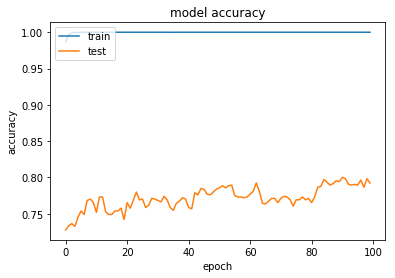

In [14]:
# summarize history for accuracy
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Score: [1.6535627887976216, 0.8001930501930502]
Normalized confusion matrix
[[0.26315789 0.01754386 0.         0.71052632 0.00877193 0.
  0.        ]
 [0.01612903 0.85483871 0.         0.11290323 0.01612903 0.
  0.        ]
 [0.00925926 0.         0.57407407 0.41666667 0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.06557377 0.         0.2295082  0.70491803 0.
  0.        ]
 [0.01694915 0.         0.         0.83050847 0.         0.15254237
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


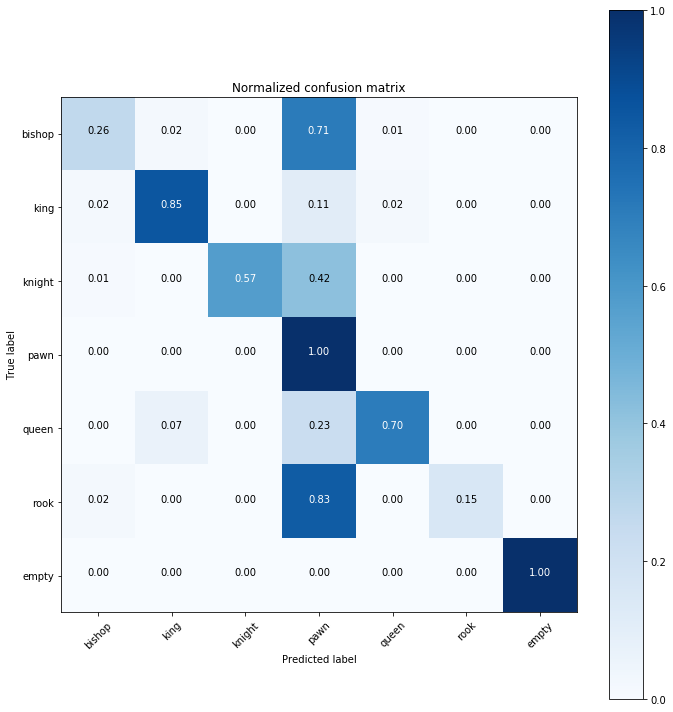

In [16]:
model.load_weights(os.path.join(model_folder_name, "chess_pieces_inceptionv3_p2.hdf5"))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=['accuracy'],
)
score = model.evaluate(X_test, y_test, verbose=0)

print("Score: " + str(score))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

test_predictions = model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')